In [1]:
import os
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
import json

from main import OncoTree, OncoNode
from util import save_result, ME_test, PR_test, Geweke, Gelman_Rubin, plot_df
from util import caset_distance, disc_distance, disc, caset, jacc
from scipy.special import logsumexp

import string
from sklearn.linear_model import LinearRegression

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
progmos_dir = 'data/synthetic/progmos/'
progmos_list = [name for name in os.listdir(progmos_dir) if name.endswith('.pkl')]

In [4]:
tree_size = {}
tree_depth = {}
tree = {}
for item in progmos_list:
    x = item.split('_')
    idx = int(x[0][1:])
    s = float(x[1][1:6])
    d = float(x[2][1:6])
    tree_size[idx] = s
    tree_depth[idx] = d
    with open(os.path.join(progmos_dir, item), 'rb') as f:
        tree[idx] = pickle.load(f)

In [5]:
e_list = [0.001, 0.01, 0.02]
m_list = [10, 30, 100, 300]

In [6]:
#df.to_csv('result/synthetic_sim_df.csv', index=None)
df = pd.read_csv('result/synthetic_sim_df.csv')

# Regressions

In [7]:
reg = LinearRegression()
x_train = np.array(df.tree_size).reshape(-1,1)
y_train = np.array(df.mx_f)
x_test = np.linspace(1,4,30).reshape(-1,1)
y_test = reg.fit(x_train,y_train).predict(x_test)

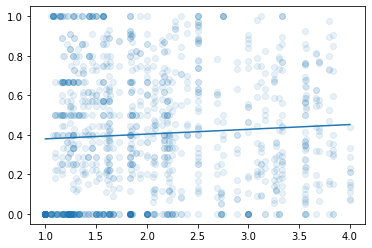

In [8]:
plt.plot(x_test,y_test)
plt.scatter(x_train,y_train, alpha=0.1)

In [9]:
for col in ['star_pri', 'star_post', 'gen_pri', 'gen_post', 'best_pri', 'best_post']:
    df = df.drop(col, axis='columns')

In [10]:
df['dataset_size'] = df['n_tumors']*df['n_genes']

# Plotting trees and parameters

In [11]:
tree_stats = df[['tree_idx', 'tree_depth', 'tree_size']].groupby('tree_idx').mean()

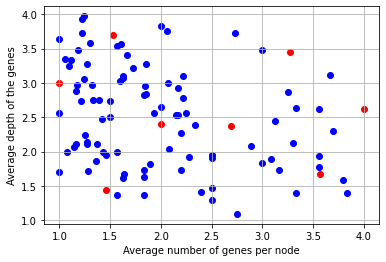

In [12]:
selected_indices = [3, 8, 19, 27, 33, 83, 88, 99]
for i in range(100):
    if i in selected_indices:
        plt.scatter(tree_stats['tree_size'][i], tree_stats['tree_depth'][i], c='r')
    else:
        plt.scatter(tree_stats['tree_size'][i], tree_stats['tree_depth'][i], c='b')
plt.xlabel('Average number of genes per node')
plt.ylabel('Average depth of the genes')
plt.grid()
#plt.savefig('figs/dataset_params.pdf')

In [13]:
tree_stats.iloc[selected_indices,:]

,tree_depth,tree_size
tree_idx,,
3.0,2.371,2.692
8.0,2.400,2.000
19.0,1.680,3.571
27.0,3.000,1.000
33.0,3.444,3.273
83.0,3.696,1.533
88.0,2.625,4.000
99.0,1.438,1.455


In [14]:
df[df['tree_idx'].isin(selected_indices)][df['gen_e']==0.001][df['n_tumors']==300].loc[:,['tree_idx','best_llh','gen_llh','gen_llh_with_model_e','mx_f', 'prog_f', 'w_mx_f', 'w_prog_f']]

/Users/mohmn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/mohmn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,tree_idx,best_llh,gen_llh,gen_llh_with_model_e,mx_f,prog_f,w_mx_f,w_prog_f
39,3.0,-1549.5017,-3369.216531,-1687.902920,0.781250,0.823529,0.989724,0.964572
99,8.0,-509.9940,-1029.881479,-509.854796,1.000000,1.000000,1.000000,1.000000
231,19.0,-1290.1972,-2543.764760,-1310.378692,0.584615,0.588235,0.973308,0.900817
327,27.0,-1094.6066,-1724.501184,-1052.162042,0.000000,0.964286,0.000000,0.997273
399,33.0,-844.5315,-2746.150036,-932.457549,0.344828,0.618911,0.954234,0.924216
999,83.0,-795.7854,-2032.940061,-743.582605,0.666667,0.676259,0.937341,0.975620
1059,88.0,-620.6158,-1524.876584,-640.737793,0.214286,0.513514,0.885335,0.927842
1191,99.0,-1521.0486,-2119.200492,-1526.275280,1.000000,1.000000,1.000000,1.000000


# Runtime analysis

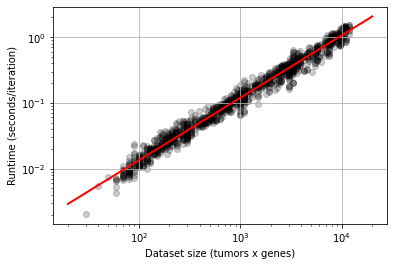

In [15]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x_train = np.log(np.array(df['dataset_size']).reshape(-1,1))
y_train = np.log((np.array(df['spent_time'])/100000).reshape(-1,1))
regr.fit(x_train, y_train)
x_range = np.arange(20, 20000).reshape(-1,1)
fig = plt.scatter(np.exp(x_train), np.exp(y_train), color="black", alpha=0.2)
plt.plot(x_range, np.exp(regr.predict(np.log(x_range))), color="red", linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dataset size (tumors x genes)')
plt.ylabel('Runtime (seconds/iteration)')
plt.grid()
plt.savefig('runtime.pdf')
plt.show()

In [16]:
regr.coef_

array([[0.95085367]])

In [17]:
new_df = deepcopy(df)
new_df['n_gen_llh'] = np.exp((new_df['gen_llh_with_model_e']-new_df['star_llh'])/new_df['n_tumors'])
new_df['n_best_llh'] = np.exp((new_df['best_llh']-new_df['star_llh'])/new_df['n_tumors'])
data_dict = {}
for idx in range(100):
    data_dict[idx] = new_df[(new_df['tree_idx']==idx)]

In [18]:
X = np.array(data_dict[0][['n_tumors','gen_e','n_gen_llh', 'n_best_llh']])
for i in range(1,100):
    X += np.array(data_dict[i][['n_tumors','gen_e','n_gen_llh', 'n_best_llh']])
X = X/100
X = pd.DataFrame(X, columns=['n_tumors','gen_e','n_gen_llh', 'n_best_llh'])

In [19]:
X

,n_tumors,gen_e,n_gen_llh,n_best_llh
0,10.0,0.001,5.054838,6.864479
1,30.0,0.001,12.597186,13.729691
2,100.0,0.001,6.367179,7.983202
3,300.0,0.001,7.757399,9.450416
4,10.0,0.010,2.960035,6.914862
5,30.0,0.010,4.600963,5.775781
6,100.0,0.010,5.797261,5.937615
7,300.0,0.010,6.508446,6.383450
8,10.0,0.020,2.496092,8.413480
9,30.0,0.020,3.643256,5.398016


# Likelihood analysis

In [20]:
df[df['gen_llh_with_model_e']>df['best_llh']].shape

(287, 28)

In [21]:
df[df['gen_llh']>df['best_llh']].shape

(2, 28)

In [22]:
data_dict = {}
for e in e_list:
    for m in m_list:
        #data_dict[(e,m)] = df[(df['gen_e']==e) & (df['n_tumors']==m) & (df['gen_llh_with_model_e']>df['best_llh'])]
        data_dict[(e,m)] = df[(df['gen_e']==e) & (df['n_tumors']==m)]

### Color: Depth
### Size: Size

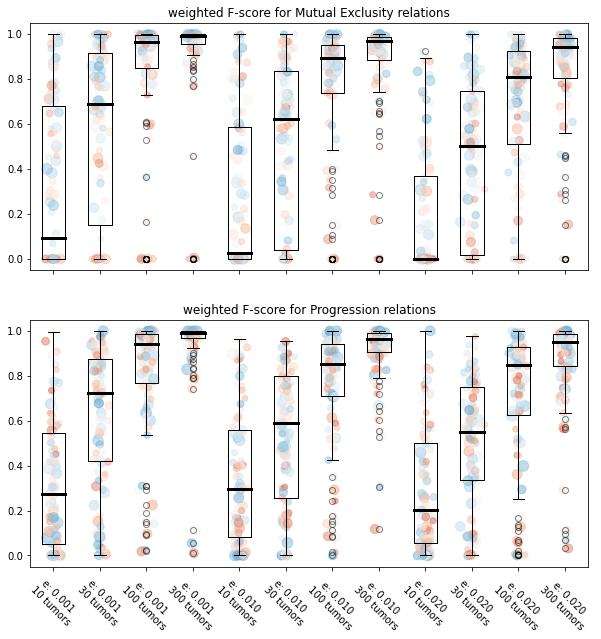

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# initialize dataframe
names, vals_mx, vals_prog, xs, clevels, msizes = [], [] ,[], [], [], []

#for i, (name, subdf) in enumerate(grouped):
for i, key in enumerate(data_dict):
    names.append('e: %.3f\n %i tumors'%key)
    #vals.append(np.exp((data_dict[key]['best_llh']-data_dict[key]['star_llh'])/data_dict[key]['n_tumors']))
    #vals.append(data_dict[key]['caset'])
    vals_mx.append(data_dict[key]['w_mx_f'])
    vals_prog.append(data_dict[key]['w_prog_f'])
    #vals.append(data_dict[key]['disc'])
    xs.append(np.random.normal(i+1, 0.07, data_dict[key].shape[0]))
    clevels.append((data_dict[key]['tree_depth'])/5)
    msizes.append((data_dict[key]['tree_size'])/5)

bp0 = axes[0].boxplot(vals_mx, labels=names, notch=False, vert=True)

for x, val, clevel, msize in zip(xs, vals_mx, clevels, msizes):
    psm = axes[0].scatter(x, val, c=cm.RdBu_r(clevel), s=150*msize, alpha=0.4)
    
_ = axes[0].set_xticklabels(['' for name in names], rotation = -45)
#psm.cmap=cm.RdBu
#fig.colorbar(psm, ax=ax, cmap=cm.RdBu)
axes[0].set_title('weighted F-score for Mutual Exclusity relations')
#ax.set_ylim(0,1)
for median in bp0['medians']:
    median.set(color ='black',
               linewidth = 3)
for cap in bp0['caps']:
    cap.set(color ='black',
            linewidth = 1)
for flier in bp0['fliers']:
    flier.set(color ='black',
              alpha = 0.5)
for box in bp0['boxes']:
    box.set(color ='black',
              alpha = 1)
for mean in bp0['means']:
    mean.set(color ='black',
              alpha = 1)
for whisker in bp0['whiskers']:
    whisker.set(color ='black',
              alpha = 1)

bp1 = axes[1].boxplot(vals_prog, labels=names, notch=False, vert=True)

for x, val, clevel, msize in zip(xs, vals_prog, clevels, msizes):
    psm = axes[1].scatter(x, val, c=cm.RdBu_r(clevel), s=150*msize, alpha=0.5)
#psm.cmap=cm.RdBu
#fig.colorbar(psm, ax=ax, cmap=cm.RdBu)
axes[1].set_title('weighted F-score for Progression relations')
#ax.set_ylim(0,1)
for median in bp1['medians']:
    median.set(color ='black',
               linewidth = 3)
for cap in bp1['caps']:
    cap.set(color ='black',
            linewidth = 1)
for flier in bp1['fliers']:
    flier.set(color ='black',
              alpha = 0.5)
for box in bp1['boxes']:
    box.set(color ='black',
              alpha = 1)
for mean in bp1['means']:
    mean.set(color ='black',
              alpha = 1)
for whisker in bp1['whiskers']:
    whisker.set(color ='black',
              alpha = 1)

_=axes[1].set_xticklabels(names, rotation = -45)
#plt.savefig('weighted_F_scores.pdf')

### color: n_genes

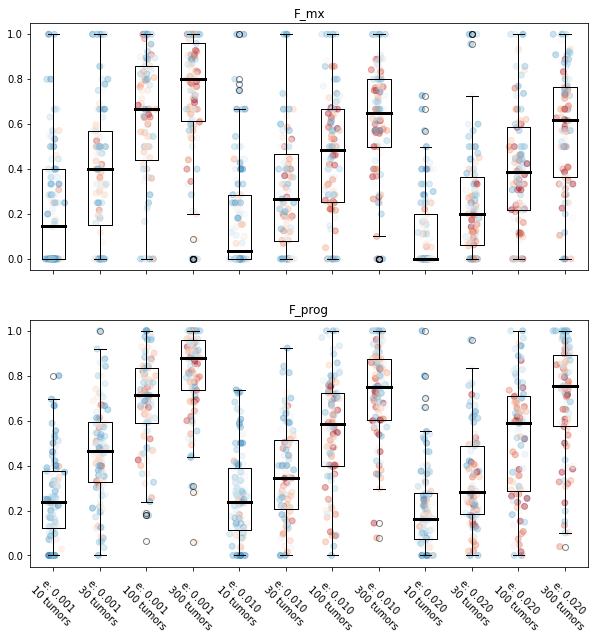

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# initialize dataframe
names, vals_mx, vals_prog, xs, clevels, msizes = [], [] ,[], [], [], []

#for i, (name, subdf) in enumerate(grouped):
for i, key in enumerate(data_dict):
    names.append('e: %.3f\n %i tumors'%key)
    #vals.append(np.exp((data_dict[key]['best_llh']-data_dict[key]['star_llh'])/data_dict[key]['n_tumors']))
    #vals.append(data_dict[key]['caset'])
    vals_mx.append(data_dict[key]['mx_f'])
    vals_prog.append(data_dict[key]['prog_f'])
    #vals.append(data_dict[key]['disc'])
    xs.append(np.random.normal(i+1, 0.07, data_dict[key].shape[0]))
    #clevels.append([color((item)/40) for item in data_dict[key]['n_genes']])
    clevels.append(data_dict[key]['n_genes']/40)

bp0 = axes[0].boxplot(vals_mx, labels=names, notch=False, vert=True)

for x, val, clevel in zip(xs, vals_mx, clevels):
    psm = axes[0].scatter(x, val, c=cm.RdBu_r(clevel), alpha=0.4)
    
_ = axes[0].set_xticklabels(['' for name in names], rotation = -45)
#psm.cmap=cm.RdBu
#fig.colorbar(psm, ax=ax, cmap=cm.RdBu)
axes[0].set_title('F_mx')
#ax.set_ylim(0,1)
for median in bp0['medians']:
    median.set(color ='black',
               linewidth = 3)
for cap in bp0['caps']:
    cap.set(color ='black',
            linewidth = 1)
for flier in bp0['fliers']:
    flier.set(color ='black',
              alpha = 0.5)
for box in bp0['boxes']:
    box.set(color ='black',
              alpha = 1)
for mean in bp0['means']:
    mean.set(color ='black',
              alpha = 1)
for whisker in bp0['whiskers']:
    whisker.set(color ='black',
              alpha = 1)

bp1 = axes[1].boxplot(vals_prog, labels=names, notch=False, vert=True)

for x, val, clevel in zip(xs, vals_prog, clevels):
    psm = axes[1].scatter(x, val, c=cm.RdBu_r(clevel), alpha=0.4)
    #psm = axes[1].scatter(x, val, c=clevel, alpha=0.4)
#psm.cmap=cm.RdBu
#fig.colorbar(psm, ax=ax, cmap=cm.RdBu)
axes[1].set_title('F_prog')
#ax.set_ylim(0,1)
for median in bp1['medians']:
    median.set(color ='black',
               linewidth = 3)
for cap in bp1['caps']:
    cap.set(color ='black',
            linewidth = 1)
for flier in bp1['fliers']:
    flier.set(color ='black',
              alpha = 0.5)
for box in bp1['boxes']:
    box.set(color ='black',
              alpha = 1)
for mean in bp1['means']:
    mean.set(color ='black',
              alpha = 1)
for whisker in bp1['whiskers']:
    whisker.set(color ='black',
              alpha = 1)

_=axes[1].set_xticklabels(names, rotation = -45)
#plt.savefig('AllCases.png')

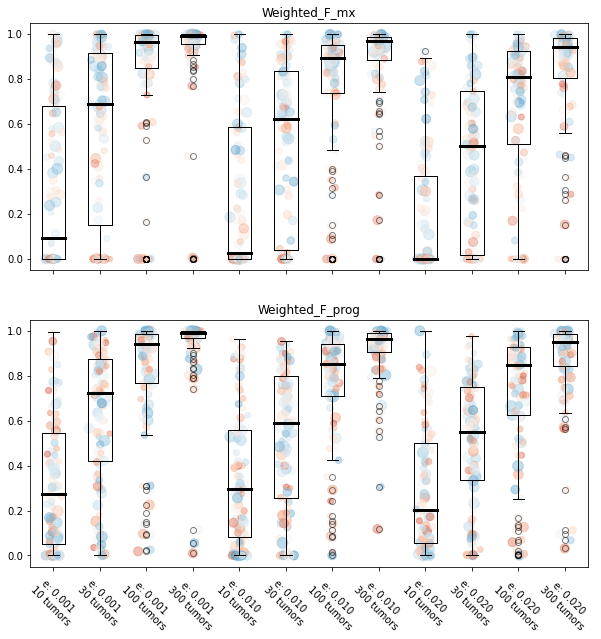

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# initialize dataframe
names, vals_mx, vals_prog, xs, clevels, msizes = [], [] ,[], [], [], []

#for i, (name, subdf) in enumerate(grouped):
for i, key in enumerate(data_dict):
    names.append('e: %.3f\n %i tumors'%key)
    #vals.append(np.exp((data_dict[key]['best_llh']-data_dict[key]['star_llh'])/data_dict[key]['n_tumors']))
    #vals.append(data_dict[key]['caset'])
    vals_mx.append(data_dict[key]['w_mx_f'])
    vals_prog.append(data_dict[key]['w_prog_f'])
    #vals.append(data_dict[key]['disc'])
    xs.append(np.random.normal(i+1, 0.07, data_dict[key].shape[0]))
    clevels.append((data_dict[key]['tree_depth'])/5)
    msizes.append((data_dict[key]['tree_size'])/5)

bp0 = axes[0].boxplot(vals_mx, labels=names, notch=False, vert=True)

for x, val, clevel, msize in zip(xs, vals_mx, clevels, msizes):
    psm = axes[0].scatter(x, val, c=cm.RdBu_r(clevel), s=150*msize, alpha=0.4)
    
_ = axes[0].set_xticklabels(['' for name in names], rotation = -45)
#psm.cmap=cm.RdBu
#fig.colorbar(psm, ax=ax, cmap=cm.RdBu)
axes[0].set_title('Weighted_F_mx')
#ax.set_ylim(0,1)
for median in bp0['medians']:
    median.set(color ='black',
               linewidth = 3)
for cap in bp0['caps']:
    cap.set(color ='black',
            linewidth = 1)
for flier in bp0['fliers']:
    flier.set(color ='black',
              alpha = 0.5)
for box in bp0['boxes']:
    box.set(color ='black',
              alpha = 1)
for mean in bp0['means']:
    mean.set(color ='black',
              alpha = 1)
for whisker in bp0['whiskers']:
    whisker.set(color ='black',
              alpha = 1)

bp1 = axes[1].boxplot(vals_prog, labels=names, notch=False, vert=True)

for x, val, clevel, msize in zip(xs, vals_prog, clevels, msizes):
    psm = axes[1].scatter(x, val, c=cm.RdBu_r(clevel), s=150*msize, alpha=0.5)
#psm.cmap=cm.RdBu
#fig.colorbar(psm, ax=ax, cmap=cm.RdBu)
axes[1].set_title('Weighted_F_prog')
#ax.set_ylim(0,1)
for median in bp1['medians']:
    median.set(color ='black',
               linewidth = 3)
for cap in bp1['caps']:
    cap.set(color ='black',
            linewidth = 1)
for flier in bp1['fliers']:
    flier.set(color ='black',
              alpha = 0.5)
for box in bp1['boxes']:
    box.set(color ='black',
              alpha = 1)
for mean in bp1['means']:
    mean.set(color ='black',
              alpha = 1)
for whisker in bp1['whiskers']:
    whisker.set(color ='black',
              alpha = 1)

_=axes[1].set_xticklabels(names, rotation = -45)
#plt.savefig('F_scores_weighted.pdf')

# CASET and DISC

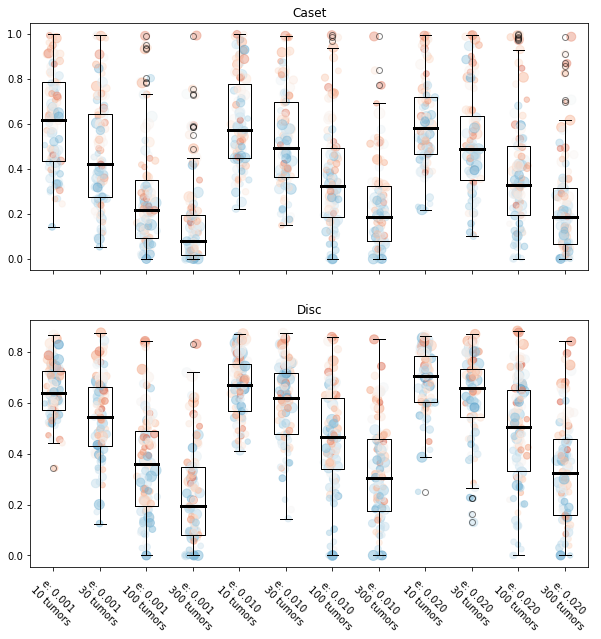

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# initialize dataframe
names, vals_caset, vals_disc, xs, clevels, msizes = [], [] ,[], [], [], []

#for i, (name, subdf) in enumerate(grouped):
for i, key in enumerate(data_dict):
    names.append('e: %.3f\n %i tumors'%key)
    #vals.append(np.exp((data_dict[key]['best_llh']-data_dict[key]['star_llh'])/data_dict[key]['n_tumors']))
    #vals.append(data_dict[key]['caset'])
    vals_caset.append(data_dict[key]['caset'])
    vals_disc.append(data_dict[key]['disc'])
    #vals.append(data_dict[key]['disc'])
    xs.append(np.random.normal(i+1, 0.07, data_dict[key].shape[0]))
    clevels.append((data_dict[key]['tree_depth'])/5)
    msizes.append((data_dict[key]['tree_size'])/5)

bp0 = axes[0].boxplot(vals_caset, labels=names, notch=False, vert=True)

for x, val, clevel, msize in zip(xs, vals_caset, clevels, msizes):
    psm = axes[0].scatter(x, val, c=cm.RdBu_r(clevel), s=150*msize, alpha=0.4)
    
_ = axes[0].set_xticklabels(['' for name in names], rotation = -45)
#psm.cmap=cm.RdBu
#fig.colorbar(psm, ax=ax, cmap=cm.RdBu)
axes[0].set_title('Caset')
#ax.set_ylim(0,1)
for median in bp0['medians']:
    median.set(color ='black',
               linewidth = 3)
for cap in bp0['caps']:
    cap.set(color ='black',
            linewidth = 1)
for flier in bp0['fliers']:
    flier.set(color ='black',
              alpha = 0.5)
for box in bp0['boxes']:
    box.set(color ='black',
              alpha = 1)
for mean in bp0['means']:
    mean.set(color ='black',
              alpha = 1)
for whisker in bp0['whiskers']:
    whisker.set(color ='black',
              alpha = 1)

bp1 = axes[1].boxplot(vals_disc, labels=names, notch=False, vert=True)

for x, val, clevel, msize in zip(xs, vals_disc, clevels, msizes):
    psm = axes[1].scatter(x, val, c=cm.RdBu_r(clevel), s=150*msize, alpha=0.5)
#psm.cmap=cm.RdBu
#fig.colorbar(psm, ax=ax, cmap=cm.RdBu)
axes[1].set_title('Disc')
#ax.set_ylim(0,1)
for median in bp1['medians']:
    median.set(color ='black',
               linewidth = 3)
for cap in bp1['caps']:
    cap.set(color ='black',
            linewidth = 1)
for flier in bp1['fliers']:
    flier.set(color ='black',
              alpha = 0.5)
for box in bp1['boxes']:
    box.set(color ='black',
              alpha = 1)
for mean in bp1['means']:
    mean.set(color ='black',
              alpha = 1)
for whisker in bp1['whiskers']:
    whisker.set(color ='black',
              alpha = 1)

_=axes[1].set_xticklabels(names, rotation = -45)
#plt.savefig('Distances.pdf')